# Apple prediction with News

In [2]:
import pandas as pd
from dasai.helpers import *

# read parquet
df = pd.read_parquet('..' / get_cleaned_data_path() / 'AAPL.parquet')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2023-02-15 to 2018-02-20
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   adjusted_close  1257 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB


In [3]:
tidy_path = '..' / get_tidy_data_path() / 'aapl_news_dense.parquet'
tidy_df = pd.read_parquet(tidy_path)

# only relevance_score_aapl and sentiment_score_aapl are used
tidy_df = tidy_df[['time_published', 'relevance_score_aapl', 'sentiment_score_aapl']]

# get the mean of the scores for each day and ignore the time
agg_df = tidy_df.groupby(tidy_df['time_published'].dt.date).mean(numeric_only=True)
agg_df['time_published'] = pd.to_datetime(agg_df.index)
agg_df.set_index('time_published', inplace=True)
merged_df = pd.merge(df, agg_df, left_index=True, right_index=True, how='inner')
merged_df.rename_axis('date', inplace=True)
merged_df

,adjusted_close,relevance_score_aapl,sentiment_score_aapl
date,,,
2022-12-23,131.659472,0.259511,0.130549
2022-12-22,131.862207,0.280631,0.040279
2022-12-21,135.073251,0.373301,0.152273
2022-12-20,131.932012,0.324814,0.015341
2022-12-19,132.001817,0.306560,0.002403
...,...,...,...
2022-03-07,158.141761,0.272079,0.047197
2022-03-04,161.983623,0.114603,0.048973
2022-03-03,165.021374,0.106414,-0.125093


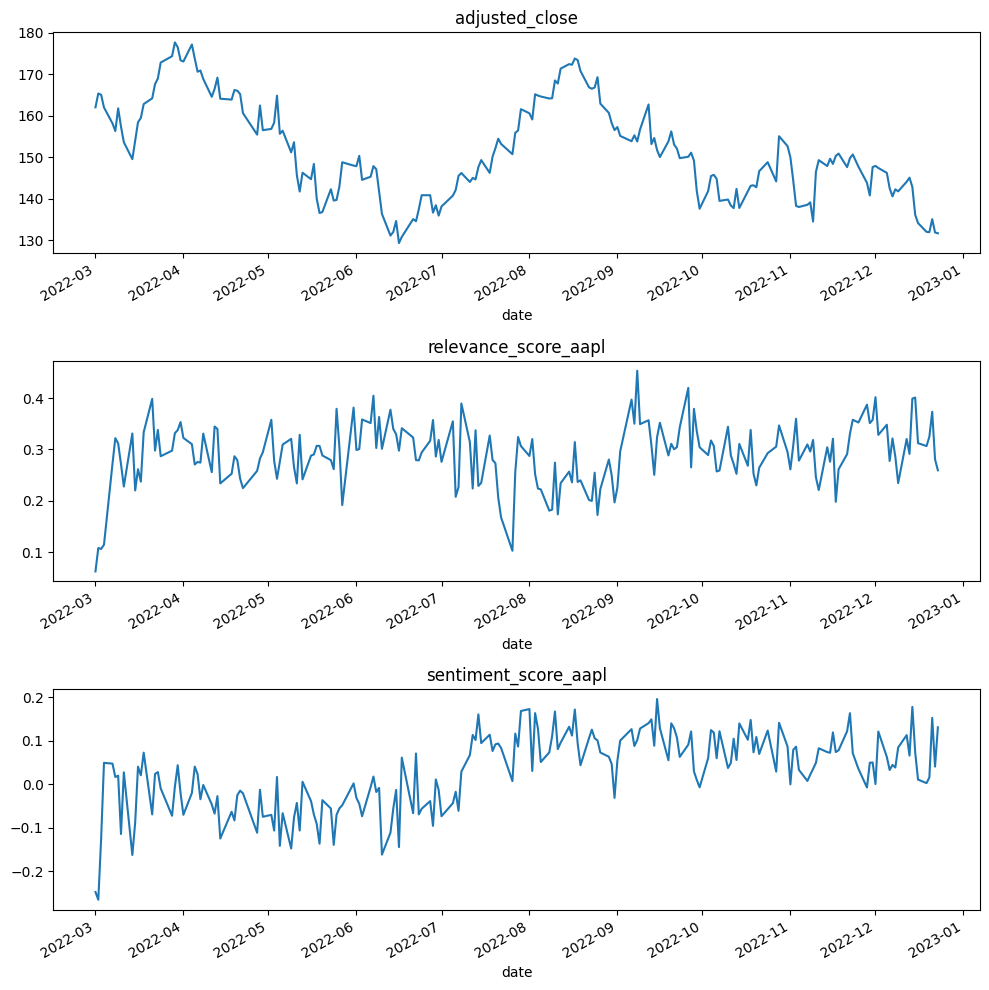

In [16]:
# plot merged_df for every column with date as x-axis in one plot each

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
for i, col in enumerate(merged_df.columns):
    merged_df[col].plot(ax=axes[i], title=col)
plt.tight_layout()
plt.show()

In [4]:
from prophet import Prophet


df_prophet = merged_df.reset_index().rename(columns={'date': 'ds', 'adjusted_close': 'y'})
# Split data into train, validation and test set
date_train = df_prophet['ds'].quantile(0.6)
date_val = df_prophet['ds'].quantile(0.8)
df_train = df_prophet[df_prophet['ds'] < date_train]

df_val = df_prophet[(df_prophet['ds'] >= date_train) & (df_prophet['ds'] < date_val)]
df_test = df_prophet[df_prophet['ds'] >= date_val]

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10],
    'holidays_prior_scale': [0.1, 1, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# from gridsearch: best params: {'changepoint_prior_scale': 1, 'seasonality_prior_scale': 10, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative'}

m = Prophet(
    changepoint_prior_scale=1,
    seasonality_prior_scale=10,
    seasonality_mode='multiplicative',
)


# add regressors
m.add_regressor('relevance_score_aapl')
m.add_regressor('sentiment_score_aapl')

m.fit(df_train)

19:48:19 - cmdstanpy - INFO - Chain [1] start processing
19:48:19 - cmdstanpy - INFO - Chain [1] done processing


## Grid search

In [106]:
from sklearn.metrics import mean_absolute_error

# fit prophet for every combination of parameters and take the best one
best_score = 0
best_params = None

for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
    for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
        for holidays_prior_scale in param_grid['holidays_prior_scale']:
            for seasonality_mode in param_grid['seasonality_mode']:
                prophet = Prophet()
                prophet.changepoint_prior_scale = changepoint_prior_scale
                prophet.seasonality_prior_scale = seasonality_prior_scale
                prophet.holidays_prior_scale = holidays_prior_scale
                prophet.seasonality_mode = seasonality_mode
                prophet.fit(df_train)
                future_val = df_val[['ds', 'relevance_score_aapl', 'sentiment_score_aapl']]
                forecast_val = prophet.predict(future_val)
                score = mean_absolute_error(forecast_val['yhat'], df_val['y'])
                best_score = float('inf')
                if score < best_score:
                    best_score = score
                    best_params = {
                        'changepoint_prior_scale': changepoint_prior_scale,
                        'seasonality_prior_scale': seasonality_prior_scale,
                        'holidays_prior_scale': holidays_prior_scale,
                        'seasonality_mode': seasonality_mode
                    }
print(f'best score: {best_score}')
print(f'best params: {best_params}')

19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:17 - cmdstanpy - INFO - Chain [1] start processing
19:22:17 - cmdstanpy - INFO - Chain [1] done processing
19:22:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
19:22:17 - cmdstanpy - INFO - Chain [1] start processing
19:22:17 - cmdstanpy - INFO - Chain [1] done processing
19:22:17 - cmdstanpy - INFO - Chain [1] start processing
19:22:17 - cmdstanpy - INFO - Chain [1] done processing
19:22:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newto

best score: 39.28481256259048
best params: {'changepoint_prior_scale': 1, 'seasonality_prior_scale': 10, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative'}


(19233.0, 19289.0)

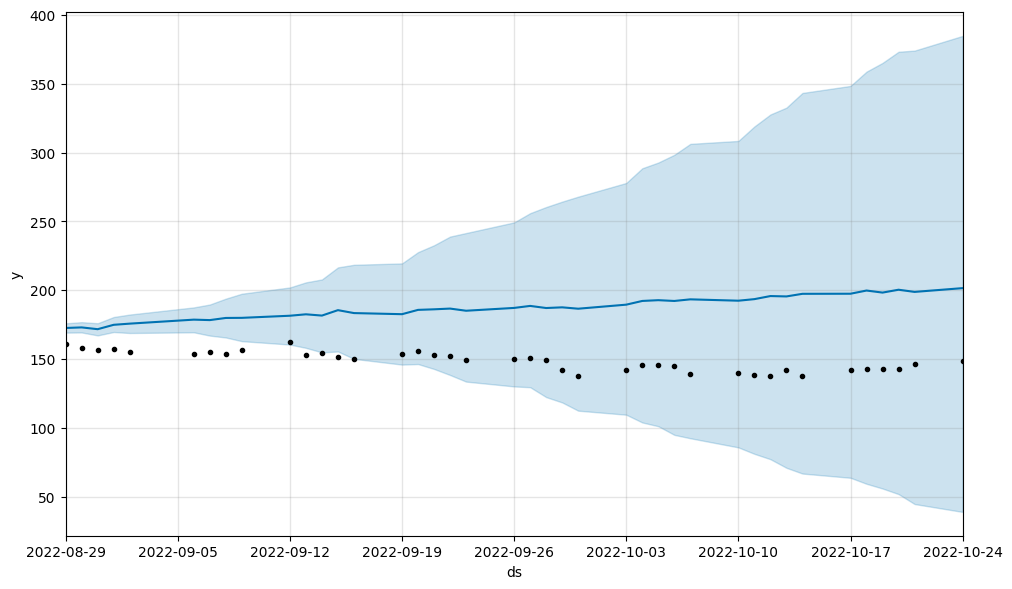

In [5]:
import matplotlib.pyplot as plt

future_val = df_val[['ds', 'relevance_score_aapl', 'sentiment_score_aapl']]

forecast_val = m.predict(future_val)
fig1 = m.plot(forecast_val)
fig1.gca().plot(df_val['ds'], df_val['y'], 'k.')
plt.xlim((df_val['ds'].min(), forecast_val['ds'].max()))

(19292.0, 19349.0)

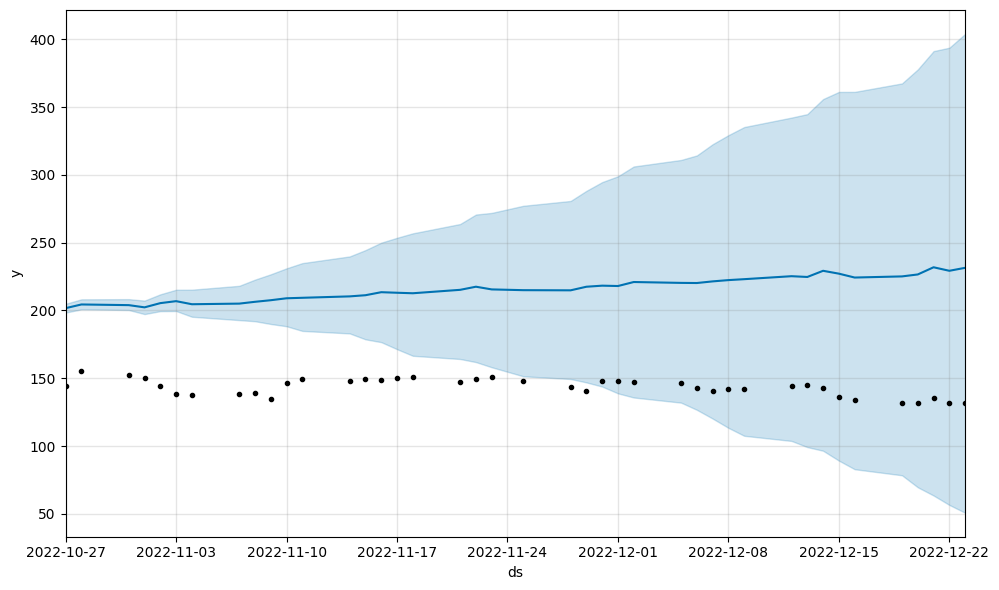

In [6]:
future_test = df_test[['ds', 'relevance_score_aapl', 'sentiment_score_aapl']]

forecast_test = m.predict(future_test)
fig1 = m.plot(forecast_test)
fig1.gca().plot(df_test['ds'], df_test['y'], 'k.')
plt.xlim((df_test['ds'].min(), forecast_test['ds'].max()))

In [7]:
# save predictions
news_result_path = '..' / get_result_data_path()
forecast_test.to_csv(news_result_path / 'aapl_news_forecast_test.csv', index=False)
forecast_val.to_csv(news_result_path / 'aapl_news_forecast_val.csv', index=False)

## Loading dense tidy data

In [60]:
import pandas as pd
from matplotlib import pyplot as plt
from dasai.helpers import *

tidy_path = '..' / get_tidy_data_path() / 'aapl_news_dense.parquet'
tidy_df = pd.read_parquet(tidy_path)

# only relevance_score_aapl and sentiment_score_aapl are used
tidy_df = tidy_df[['time_published', 'relevance_score_aapl', 'sentiment_score_aapl']]

# get the mean of the scores for each day and ignore the time
agg_df = tidy_df.groupby(tidy_df['time_published'].dt.date).mean(numeric_only=True)
agg_df

,time_published,relevance_score_aapl,sentiment_score_aapl
index,,,
0,2022-03-04 13:50:06,0.304774,0.078917
1,2022-03-02 08:00:00,0.195245,-0.420224
2,2022-03-03 08:00:00,0.164618,-0.249584
3,2022-03-03 08:00:00,0.149718,0.041408
4,2022-03-04 15:50:00,0.136966,0.099433
...,...,...,...
8219,2022-12-23 15:52:33,0.034630,-0.014457
8220,2022-12-23 22:55:31,0.030878,-0.043919
8221,2022-12-21 19:30:00,0.025651,0.209045


In [66]:
# get the mean of the scores for each day and ignore the time
agg_df = tidy_df.groupby(tidy_df['time_published'].dt.date).mean(numeric_only=True)
agg_df

,relevance_score_aapl,sentiment_score_aapl
time_published,,
2022-03-01,0.062711,-0.247750
2022-03-02,0.108298,-0.265587
2022-03-03,0.106414,-0.125093
2022-03-04,0.114603,0.048973
2022-03-05,0.120783,-0.496675
...,...,...
2022-12-20,0.324814,0.015341
2022-12-21,0.373301,0.152273
2022-12-22,0.280631,0.040279


## Saving dense news data as tidy data

Due to limitations with the API we had to manually and iteratively download the daily data. Otherwise the data would have been clustered at month end.

In [18]:
from dasai.aapl_news.tidy_data import tidy_and_save_news

# change to .. folder
os.chdir('..')
tidy_and_save_news('aapl_news_dense.json', 'aapl_news_dense.parquet')
# go back to previous folder
os.chdir('notebooks_private')


original shape: (8224, 6)
original columns: Index(['index', 'time_published', 'source', 'category_within_source',
       'overall_sentiment_score', 'ticker_sentiment'],
      dtype='object')
lists: ['ticker_sentiment'], dicts: []
exploding: ticker_sentiment
lists: [], dicts: ['ticker_sentiment']
flattening: ticker_sentiment
lists: [], dicts: []
final shape: (48620, 9)
final columns: Index(['index', 'time_published', 'source', 'category_within_source',
       'overall_sentiment_score', 'ticker_sentiment.ticker',
       'ticker_sentiment.relevance_score',
       'ticker_sentiment.ticker_sentiment_score',
       'ticker_sentiment.ticker_sentiment_label'],
      dtype='object')
Dataframe has been saved at data\tidy_data\aapl_news_dense.parquet
